In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from typing import Dict

def plot_results(
    res: Dict[str, np.ndarray], 
    title: str = "", 
    mle_off: bool = False, 
    med_off: bool = False,
):
    plt.figure()
    for k,v in res.items():
        match k:
            case "MMD":
                plt.plot(res["eps"], v, linestyle=":", c="red", label=k)
            case "Improved MMD":
                plt.plot(res["eps"], v, linestyle=":", c="purple", label=k)
            case "MLE":
                if not mle_off:
                    plt.plot(res["eps"], v, linestyle=":", c="blue", label=k)
            case "MED":
                if not med_off:
                    plt.plot(res["eps"], v, linestyle=":", c="green", label=k)
    plt.xlabel("Ratio of outliers")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# baseline: simulate data from Gaussian model
def mle_mean_np(x: np.ndarray) -> np.ndarray:
    return x.mean(axis=0)

def median_np(x: np.ndarray) -> np.ndarray:
    return np.median(x, axis=0)

In [4]:
# utilities
from typing import Callable

def _gaussian_kernel(a: torch.Tensor, b: torch.Tensor, bw: float) -> torch.Tensor:
    """
    a: (N, d), b: (M, d)
    returns K: (N, M) with k(x,y)=exp(-||x-y||^2 / bw)
    NOTE: Use torch.cdist which is efficient on GPU; keep everything on the same device.
    """
    return torch.exp(-torch.cdist(a, b) ** 2 / bw)

def _simulate_gaussian_mean(theta: torch.Tensor, eps_y: torch.Tensor, sigma_x2: float = 1.0) -> torch.Tensor:
    """
    theta: (M, d)
    eps_y: (M, S, d) ~ N(0, I)
    returns Y: (M, S, d) with Y = theta[:,None,:] + sqrt(sigma_x2) * eps_y
    """
    return theta[:, None, :] + (sigma_x2 ** 0.5) * eps_y

def _E_mmd2(
    X: torch.Tensor,
    Y: torch.Tensor,
    kernel_fn: Callable,
    bw: float,
    M: int,
    S: int,
) -> torch.Tensor:
    """
    Existing-method MMD^2:
        (1/M) * sum_i MMD^2(P_{θ_i},  P̂_n)
    Inputs:
      - X: (n, d)              data (empirical distribution P̂_n)
      - Y: (M, S, d) or (M*S, d)
            samples from each particle's model P_{θ_i}
      - M: number of particles
      - kernel_fn(a,b,bw): returns K (|a|, |b|)
      - bw: RBF bandwidth (scalar)

    Returns:
      - scalar tensor: (1/M) Σ_i MMD^2(P_{θ_i}, P̂_n)
    """
    n, d = X.shape

    Kxx = kernel_fn(X, X, bw).mean() # E_{X,X}[k(X,X)]
    Kxy = kernel_fn(X, Y, bw).view(n, M, S).mean(dim=(0, 2)) # E_{X,Y_i}[k(X,Y)]
    Kyy = kernel_fn(Y, Y, bw)\
      .view(M, S, M, S)\
      .diagonal(dim1=0, dim2=2)\
      .permute(2, 0, 1)\
      .mean(dim=(1, 2)) # E_{Y_i,Y_i}[k(Y,Y)]             

    mmd2 = Kxx - 2 * Kxy + Kyy
    return mmd2.mean()

def _mix_mmd2(
    X: torch.Tensor,
    Y: torch.Tensor,
    kernel_fn: Callable,
    bw: float,
) -> torch.Tensor:
    """
    Mixture MMD^2 (proposed method's first term):
        MMD^2( mix = (1/M) Σ_i P_{θ_i},  P̂_n )
    Inputs:
      - X: (n, d) data (empirical distribution P̂_n)
      - Y: (M*M, d) pooled samples from all particles (mixture samples)
      - kernel_fn(a,b,bw): returns K (|a|, |b|)
      - bw: RBF bandwidth (scalar)

    Returns:
      - scalar tensor: MMD^2(mix, P̂_n)
    """
    Kxx = kernel_fn(X, X, bw).mean()  # E_{X,X}[k]
    Kxy = kernel_fn(X, Y, bw).mean()  # E_{X,mix}[k]
    Kyy = kernel_fn(Y, Y, bw).mean()  # E_{mix}[k]
    return Kxx - 2 * Kxy + Kyy

def _var_emb(
    Y: torch.Tensor, 
    kernel_fn: Callable, 
    bw: float, 
    M: int, 
    S: int,
) -> torch.Tensor:
    """
    Embedding-variance term (vectorized):
      E_q E_{Y,Y'~P_θ}[k(Y,Y')]  -  E_{Y,Y'~mix}[k(Y,Y')]
    Inputs:
      - Y: (M*M, d) pooled samples from all particles (mixture samples)
      - kernel_fn(a,b,bw): returns K (|a|, |b|)
      - bw: RBF bandwidth (scalar)
      - M: number of particles
      - S: samples per particle

    Returns:
      - scalar tensor: embedding variance
    """
    K = kernel_fn(Y, Y, bw)                                   
    pooled = K.mean()                                         
    within = K.view(M, S, M, S).diagonal(dim1=0, dim2=2).mean()
    return within - pooled

In [5]:
# existing method (MFLD, GPU-optimized & vectorized)
import math
import torch
from typing import Callable, Optional, Tuple

def vi_mmd(
    X: torch.Tensor,
    beta: float,
    steps: int = 1000,
    beta_schedule: Callable = lambda t, T, beta: beta * min(1, (t + 1) / (0.1 * T)),
    lr: float = 5e-3,                                 
    M: int = 32,                                      
    S: int = 32,                                      
    kernel_fn: Callable = _gaussian_kernel,
    simulate_fn: Callable = _simulate_gaussian_mean,  
    prior_tau2: float = 1.0,                          
    lambda_kl: float = 0.005,                           
    device: Optional[str] = None,
    dtype: torch.dtype = torch.float64,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Optimize (existing objective) via Mean-Field Langevin Dynamics (MFLD):
        L(μ) = KL(μ || π) + β * (1/M) Σ_i MMD^2(P_{θ_i},  P̂)
    Particle approximation: μ ≈ (1/M) Σ_i δ_{θ_i}
    Vectorized implementation: compute all-particle MMD terms in one shot on GPU.
    Inputs:
      - X: (n, d) data (empirical distribution P̂_n)
      - beta: weight of MMD term
      - steps: number of Langevin steps
      - lr: Langevin step size (η)
      - M: number of particles
      - S: synthetic samples per particle
      - kernel_fn(a,b,bw): returns K (|a|, |b|) 
      - simulate_fn(theta, eps_y): returns Y (M, S, d) samples from P_{θ_i}
      - prior_tau2: prior variance for Gaussian π = N(0, τ^2 I)
      - lambda_kl: weight of KL/entropy; noise uses sqrt(2 * lambda_kl * lr)
    
    Returns:
        - m_hat:      (d,) numpy array — empirical mean of particles
        - sigma2_hat: (d,) numpy array — empirical variance (diagonal) of particles
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    X = X.to(device, dtype=dtype)
    n, d = X.shape

    with torch.no_grad():
        idx = torch.randperm(n, device=device)[:min(1000, n)]
        pair = torch.pdist(X[idx])
        bw = pair.median().pow(2).item()
        if bw < 1e-6:
            bw = float(d)

    # particles initialization
    theta = (prior_tau2 ** 0.5) * torch.randn(M, d, device=device, dtype=dtype)
    theta.requires_grad_(True)

    for t in range(1, steps + 1):
        beta_t = beta_schedule(t, steps, beta)

        # sampling P_{θ_{1:M}}
        Y = simulate_fn(theta, eps_y=torch.randn(M, S, d, device=device, dtype=dtype))
        Y = Y.reshape(M * S, d)               

        # potential U(θ_{1:M})
        mmd_term = _E_mmd2(X, Y, kernel_fn, bw, M, S) 
        prior_term = (lambda_kl / (2.0 * prior_tau2)) * theta.pow(2).sum()
        U = beta_t * mmd_term + prior_term

        # Langevin step
        grads = torch.autograd.grad(U, theta, create_graph=False)[0]
        with torch.no_grad():
            noise = torch.randn_like(theta) * math.sqrt(2.0 * lambda_kl * lr)
            theta.add_(-lr * grads + noise)
        theta.requires_grad_(True)

    m_hat = theta.detach().mean(dim=0).cpu().numpy()
    sigma2_hat = theta.detach().var(dim=0, unbiased=False).cpu().numpy()
    return m_hat, sigma2_hat


In [6]:
# proposed method (MFLD, GPU-optimized & vectorized)
import math
import torch
from typing import Callable, Optional, Tuple

def vi_mix_mmd(
    X: torch.Tensor,
    beta: float,
    alpha: float = 200,
    steps: int = 1000,
    beta_schedule: Callable = lambda t, T, beta: beta * min(1, (t + 1) / (0.1 * T)),
    lr: float = 5e-3,                               
    M: int = 32,                                     
    S: int = 32,                                     
    kernel_fn: Callable = _gaussian_kernel,
    simulate_fn: Callable = _simulate_gaussian_mean, 
    prior_tau2: float = 1.0,                         
    lambda_kl: float = 0.005,                          
    device: Optional[str] = None,
    dtype: torch.dtype = torch.float64,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Optimize the proposed objective via Mean-Field Langevin Dynamics (MFLD):
        L(μ) = β * MMD^2( E_{θ~μ}[P_θ],  P̂ )
             + α * E_{θ~μ}[ MMD^2( P_θ,  E_{θ~μ}[P_θ] ) ]
             + λ * KL(μ || π)
    Vectorized implementation on GPU:
      - Compute all pairwise kernels only once per step (A vs A, X vs A).
      - Reuse cached E[k(X,X)] across steps.
    Inputs:
      - X: (n, d) data (empirical distribution P̂_n)
      - beta: weight of MMD term
      - steps: number of Langevin steps
      - lr: Langevin step size (η)
      - M: number of particles
      - S: synthetic samples per particle
      - kernel_fn(a,b,bw): returns K (|a|, |b|) 
      - simulate_fn(theta, eps_y): returns Y (M, S, d) samples from P_{θ_i}
      - prior_tau2: prior variance for Gaussian π = N(0, τ^2 I)
      - lambda_kl: weight of KL/entropy; noise uses sqrt(2 * lambda_kl * lr)
    
    Returns:
      - m_hat:      (d,) numpy array — empirical mean of particles
      - sigma2_hat: (d,) numpy array — empirical variance (diagonal) of particles
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
    X = X.to(device, dtype=dtype)
    n, d = X.shape

    with torch.no_grad():
        idx = torch.randperm(n, device=device)[:min(1000, n)]
        pair = torch.pdist(X[idx])
        bw = pair.median().pow(2).item()
        if bw < 1e-6:
            bw = float(d)

    # particles initialization
    theta = (prior_tau2 ** 0.5) * torch.randn(M, d, device=device, dtype=dtype)
    theta.requires_grad_(True)

    for t in range(1, steps + 1):
        beta_t = beta_schedule(t, steps, beta)

        # sampling P_{θ_{1:M}}
        Y = simulate_fn(theta, eps_y=torch.randn(M, S, d, device=device, dtype=dtype))
        Y = Y.reshape(M * S, d)

        # potential U(θ_{1:M})
        mmd_term = _mix_mmd2(X, Y, kernel_fn, bw) 
        var_term = _var_emb(Y, kernel_fn, bw, M, S)
        prior_term = (lambda_kl / (2.0 * prior_tau2)) * theta.pow(2).sum()
        U = beta_t * mmd_term + alpha * var_term + prior_term

        # Langevin step
        grads = torch.autograd.grad(U, theta, create_graph=False)[0]
        with torch.no_grad():
            noise = torch.randn_like(theta) * math.sqrt(2.0 * lambda_kl * lr)
            theta.add_(-lr * grads + noise)
        theta.requires_grad_(True)

    m_hat = theta.detach().mean(dim=0).cpu().numpy()
    sigma2_hat = theta.detach().var(dim=0, unbiased=False).cpu().numpy()
    return m_hat, sigma2_hat


In [11]:
def run(
    dim: int = 1, 
    contam_rates: np.ndarray = np.linspace(0, 0.2, 9), 
    T: int = 500, 
    R: int = 100,
    M: int = 32,
    S: int = 32, 
    seed: Optional[int] = None, 
    device: Optional[str] = None,
) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)
    n = 200
    rmse_mle = []
    rmse_med = []
    rmse_mmd = []
    rmse_imp = []

    for _, eps in enumerate(contam_rates):
        se_mle = se_med = se_mmd = se_imp = 0.0
        for _ in trange(R, leave=False, desc=f"ε={eps:.3f}"):
            theta0 = np.full(dim, 2.0)
            data = rng.normal(theta0, 1.0, size=(n, dim))
            m_out = int(eps * n)
            if m_out > 0:
                data[:m_out] = rng.standard_cauchy(size=(m_out, dim))
                rng.shuffle(data)

            X_ = torch.from_numpy(data).float().to(device)
            beta = n * dim
            
            mu_mle = mle_mean_np(data)
            mu_med = median_np(data)
            m_mmd, _ = vi_mmd(X_, beta, steps=T, M=M, S=S, device=device)
            m_imp, _ = vi_mix_mmd(X_, beta, alpha=0.8 * beta, steps=T, M=M, S=S, device=device)

            se_mle += np.mean((mu_mle - theta0) ** 2)
            se_med += np.mean((mu_med - theta0) ** 2)
            se_mmd += np.mean((m_mmd - theta0) ** 2)
            se_imp += np.mean((m_imp - theta0) ** 2)

        rmse_mle.append(np.sqrt(se_mle / R))
        rmse_med.append(np.sqrt(se_med / R))
        rmse_mmd.append(np.sqrt(se_mmd / R))
        rmse_imp.append(np.sqrt(se_imp / R))

    return {
        "eps": contam_rates,
        "MLE": np.array(rmse_mle),
        "MED": np.array(rmse_med),
        "MMD": np.array(rmse_mmd),
        "Improved MMD": np.array(rmse_imp),
    }


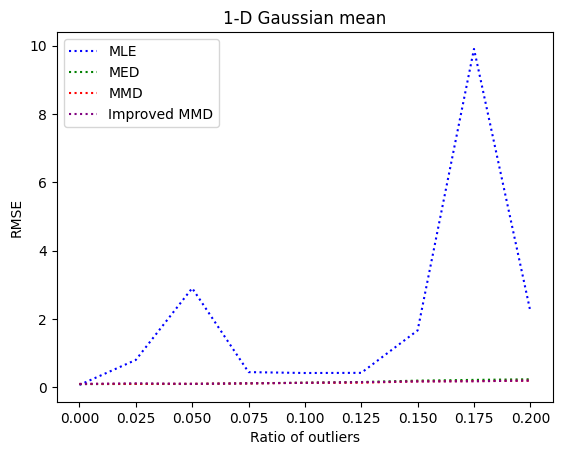

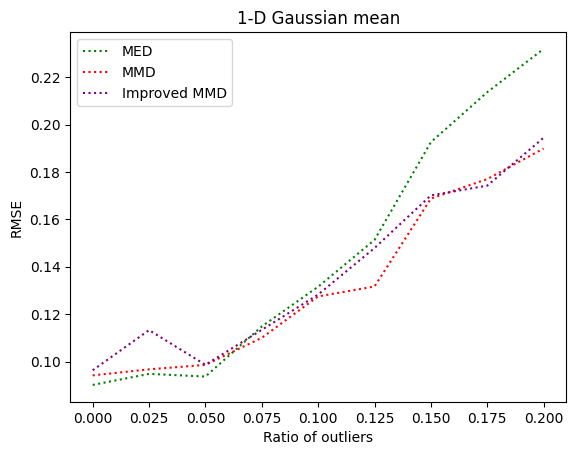

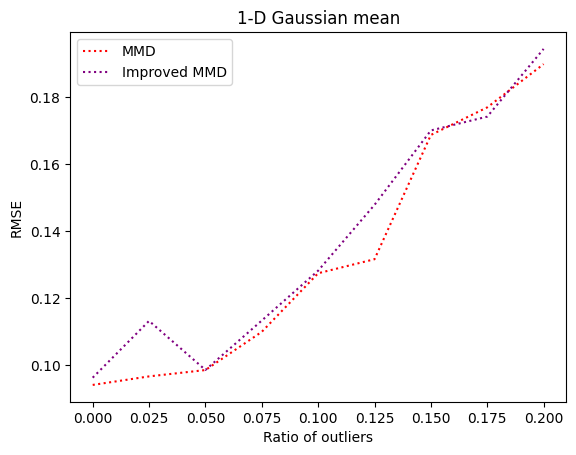

In [14]:
# 1-D Gaussian mean
res_1d = run(dim=1, contam_rates=np.linspace(0, 0.2, 9), T=1000, R=100, M=32, S=32, seed=None, device=device)
plot_results(res_1d, "1-D Gaussian mean")
plot_results(res_1d, "1-D Gaussian mean", mle_off=True)
plot_results(res_1d, "1-D Gaussian mean", mle_off=True, med_off=True)

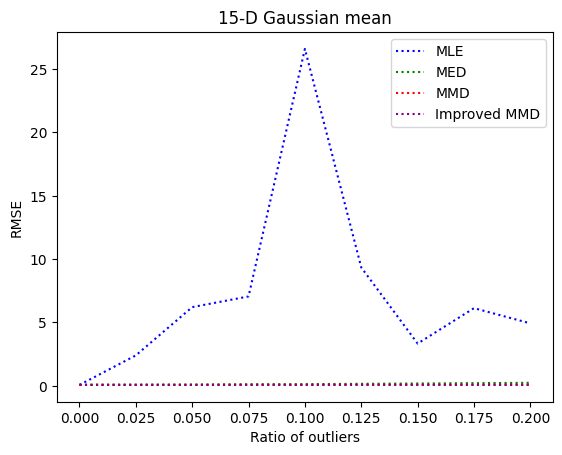

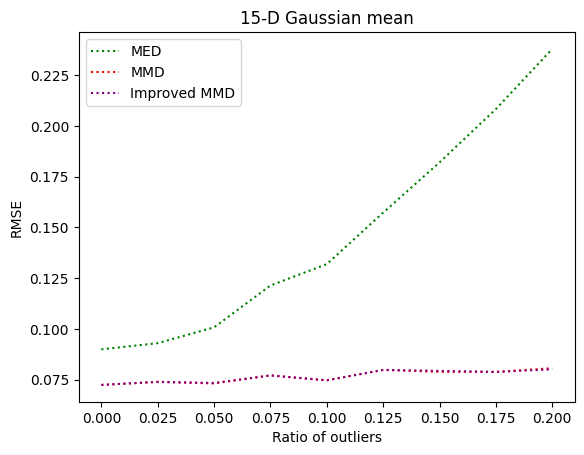

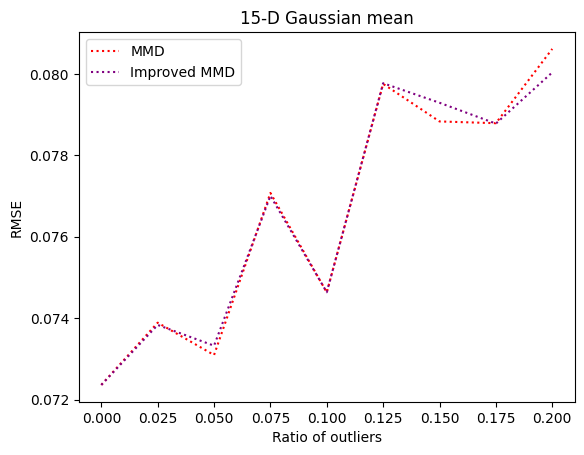

In [15]:
# 15-D Gaussian mean
res_15d = run(dim=15, contam_rates=np.linspace(0, 0.2, 9), T=1500, R=100, M=32, S=32, seed=None, device=device)
plot_results(res_15d, "15-D Gaussian mean")
plot_results(res_15d, "15-D Gaussian mean", mle_off=True)
plot_results(res_15d, "15-D Gaussian mean", mle_off=True, med_off=True)